In [3]:
# AI Music Generation App
#importing all the long short term memory models
import collections
import datetime
import fluidsynth 
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [4]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [16]:
# Recursively get all .mid files from dataset folder
import pathlib

data_dir = pathlib.Path(r"dataset\lmd_full\lmd_full")

# Recursively search for all .mid files
midi_files = list(data_dir.glob("**/*.mid"))

print(f"Found {len(midi_files)} MIDI files")
for f in midi_files[:5]:
    print(f)



Found 178561 MIDI files
dataset\lmd_full\lmd_full\0\00000ec8a66b6bd2ef809b0443eeae41.mid
dataset\lmd_full\lmd_full\0\0000799e8672292fe6f0fff08554ca40.mid
dataset\lmd_full\lmd_full\0\00012722c199ae2a628ebb792ccc617a.mid
dataset\lmd_full\lmd_full\0\000203a04a64ad57329a058f11e235cb.mid
dataset\lmd_full\lmd_full\0\00032fb2047d3cdd0394b89349d858b4.mid


In [17]:
sample_file = midi_files[1]
print(sample_file)

dataset\lmd_full\lmd_full\0\0000799e8672292fe6f0fff08554ca40.mid


In [19]:
pm = pretty_midi.PrettyMIDI(str(sample_file))


In [20]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [21]:
display_audio(pm)

In [22]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)


Number of instruments: 4
Instrument name: Acoustic Grand Piano


In [23]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=64, note_name=E4, duration=0.0929
1: pitch=45, note_name=A2, duration=0.5912
2: pitch=52, note_name=E3, duration=0.3463
3: pitch=57, note_name=A3, duration=0.0591
4: pitch=59, note_name=B3, duration=0.0338
5: pitch=72, note_name=C5, duration=1.3091
6: pitch=43, note_name=G2, duration=0.3294
7: pitch=50, note_name=D3, duration=0.3041
8: pitch=55, note_name=G3, duration=0.0422
9: pitch=57, note_name=A3, duration=0.0338


In [24]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [26]:
raw_notes = midi_to_notes(str(sample_file))
raw_notes.head()

,pitch,start,end,step,duration
0,64,0.000000,0.092905,0.000000,0.092905
1,45,0.042230,0.633445,0.042230,0.591216
2,72,0.059122,1.368242,0.016892,1.309120
3,52,0.354729,0.701013,0.295608,0.346283
4,57,0.684121,0.743243,0.329392,0.059122


In [27]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['E4', 'A2', 'C5', 'E3', 'A3', 'B3', 'B4', 'G2', 'D3', 'G3'],
      dtype='<U2')

In [28]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

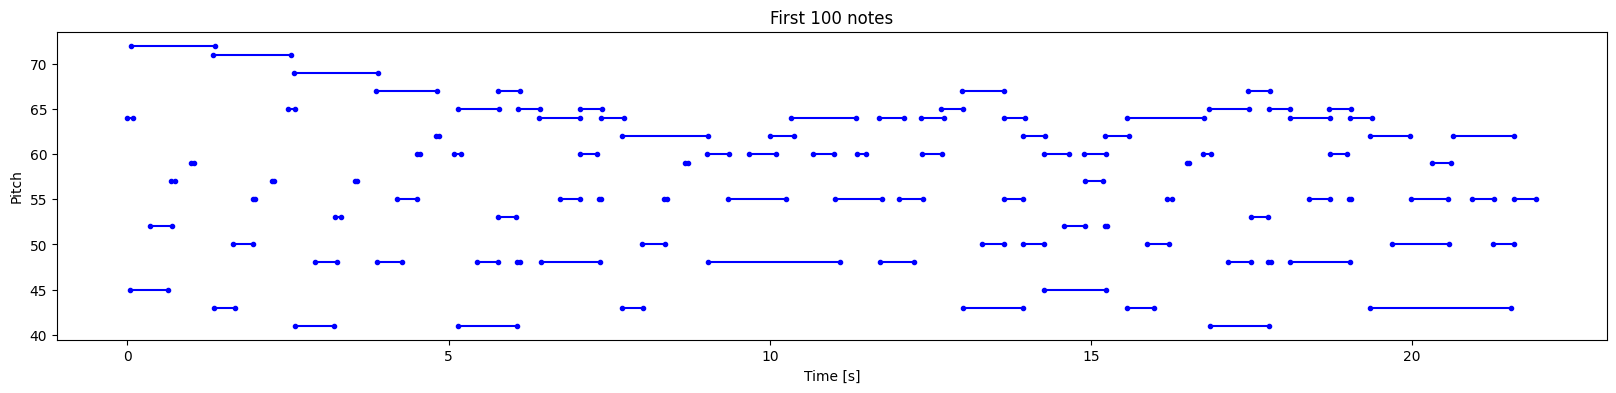

In [29]:
plot_piano_roll(raw_notes, count=100)

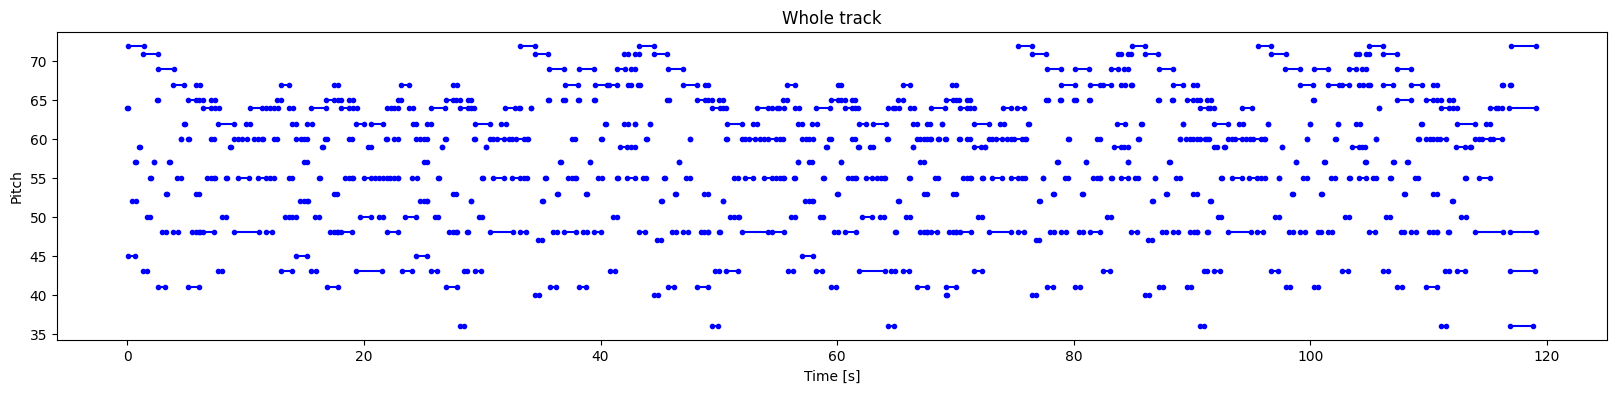

In [30]:
plot_piano_roll(raw_notes)

In [31]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

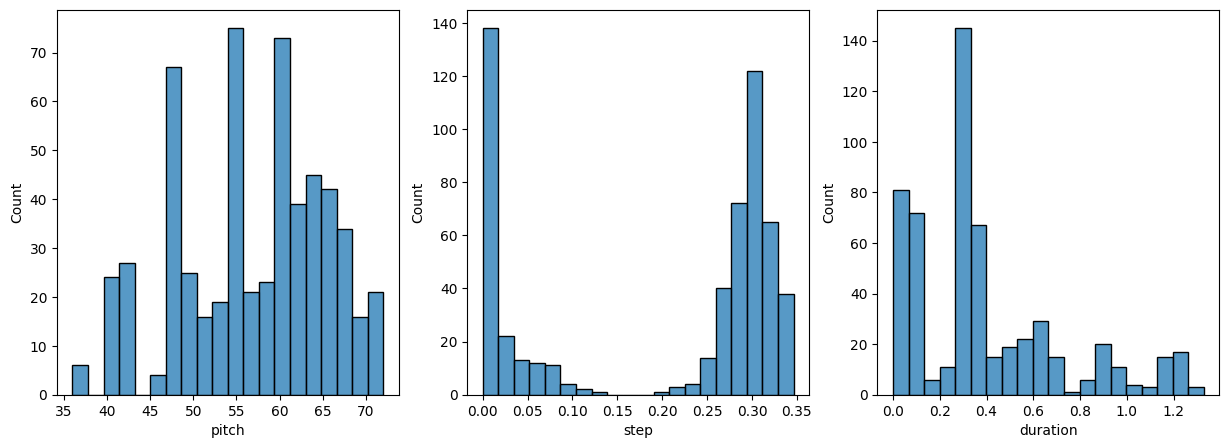

In [32]:
plot_distributions(raw_notes)

In [33]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [34]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [35]:
display_audio(example_pm)

In [38]:
num_files = 5
all_notes = []
for f in midi_files[:num_files]:
  notes = midi_to_notes(str(f))
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [39]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 3388


In [40]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [41]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [42]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [43]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [44]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.609375   0.         0.10135125]
 [0.515625   0.10135125 0.10135125]
 [0.640625   0.10135125 0.10135125]
 [0.515625   0.10135125 0.10135125]
 [0.625      0.10135125 0.10135125]
 [0.515625   0.10135125 0.10135125]
 [0.5625     0.10135125 0.10135125]
 [0.515625   0.10135125 0.10135125]
 [0.5703125  0.10135125 0.10135125]
 [0.515625   0.10135125 0.10135125]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=63.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.10135125>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.10135125>}


In [45]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [46]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [47]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [48]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                             

In [49]:
losses = model.evaluate(train_ds, return_dict=True)
losses



52/52 [==============================] - 4s 18ms/step - loss: 11.2615 - duration_loss: 0.7638 - pitch_loss: 4.8579 - step_loss: 5.6398


{'loss': 11.261506080627441,
 'duration_loss': 0.7637878656387329,
 'pitch_loss': 4.857876300811768,
 'step_loss': 5.6398420333862305}

In [50]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [51]:
model.evaluate(train_ds, return_dict=True)

52/52 [==============================] - 2s 12ms/step - loss: 6.6465 - duration_loss: 0.7638 - pitch_loss: 4.8579 - step_loss: 5.6398


{'loss': 6.646522521972656,
 'duration_loss': 0.7637878656387329,
 'pitch_loss': 4.857876300811768,
 'step_loss': 5.6398420333862305}

In [52]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [53]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
52/52 [==============================] - 6s 28ms/step - loss: 5.9533 - duration_loss: 0.1054 - pitch_loss: 4.3233 - step_loss: 5.6317
Epoch 2/50
52/52 [==============================] - 1s 23ms/step - loss: 5.8277 - duration_loss: 0.0822 - pitch_loss: 3.4684 - step_loss: 5.5720
Epoch 3/50
52/52 [==============================] - 1s 19ms/step - loss: 5.7733 - duration_loss: 0.0801 - pitch_loss: 3.3556 - step_loss: 5.5255
Epoch 4/50
52/52 [==============================] - 1s 19ms/step - loss: 5.7375 - duration_loss: 0.0778 - pitch_loss: 3.2870 - step_loss: 5.4953
Epoch 5/50
52/52 [==============================] - 1s 17ms/step - loss: 5.5037 - duration_loss: 0.0792 - pitch_loss: 3.1999 - step_loss: 5.2645
Epoch 6/50
52/52 [==============================] - 1s 15ms/step - loss: 5.0868 - duration_loss: 0.0799 - pitch_loss: 3.1718 - step_loss: 4.8484
Epoch 7/50
52/52 [==============================] - 1s 17ms/step - loss: 4.7685 - duration_loss: 0.0780 - pitch_loss: 3.1617 - ste

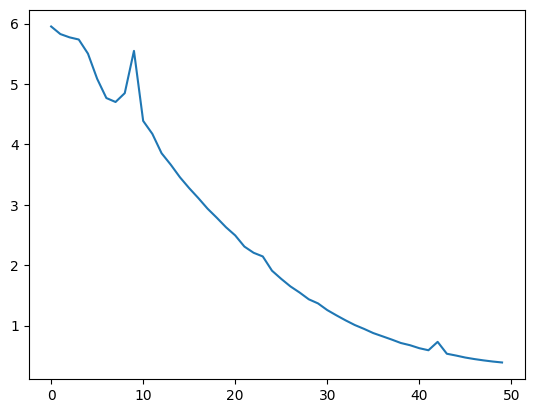

In [54]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [55]:
def predict_next_note(
    notes: np.ndarray, 
    model: tf.keras.Model, 
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [76]:
temperature = 2.0
num_predictions = 100

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 22ms/step


In [77]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,67,0.206412,0.449117,0.206412,0.655529
1,60,0.523643,0.352075,0.730056,1.082130
2,41,0.710675,0.327413,1.440731,1.768144
3,70,0.622030,0.340725,2.062760,2.403485
4,59,1.580154,0.392584,3.642914,4.035498
5,59,2.014916,0.367205,5.657830,6.025035
6,70,2.492470,0.345033,8.150300,8.495333
7,70,2.971170,0.327912,11.121470,11.449381
8,58,3.201102,0.307524,14.322572,14.630096
9,55,3.344479,0.316192,17.667051,17.983242


In [78]:
out_file = 'output5.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [79]:
# Save to MIDI file
out_pm.write(out_file)
print(f"MIDI saved to {out_file}")


MIDI saved to output5.mid
